In [3]:
import numpy as np
from scipy.linalg import expm
from random import sample, shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
nT = 20

#System evolution -> return max excitation (among the nT steps calculated)
def evolve(r0, H, t):
    N_in = H.shape[0]
    
    I = np.eye(N_in, dtype="complex64")
    L_uni = np.kron(I, H) - np.kron(H.transpose().conjugate(), I)
    dt = t/float(nT)
    
    rt = r0
    Mp = rt.real[0]
    for ti in range(nT):
        rt = expm((1j*L_uni)*dt)@rt
        Mp = max(Mp, rt[0].real)
    return Mp


#Chain class
class QNetwork:
    def __init__(self, J0=1., T=1., N_max=11):
        self.J=J0
        self.T=T
        self.DE=1.
        self.N_max=N_max
        
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([1.]), np.array([0.])]
   
        self.H=np.zeros([2,2], dtype="complex64")
        self.H[0,0]=self.DE
        self.H[1,1]=self.DE
        self.H[0,1]=self.J
        self.H[1,0]=self.J
        self.rho0=np.zeros([2,2])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(4)
    
    #Interactions
    def H_ij(self, x_i, x_j):
        return self.J/((np.linalg.norm(x_j-x_i))**3)
    
    #Add new node to the chain and update Hamiltonian and state
    def add_node(self, nx):
        self.nodes_coordinates[nx]=1.
        x=float(nx)/(self.N_max-1)
        
        id_last=self.H.shape[0]
        H_new = self.H.copy()
        H_new=np.vstack((np.hstack((H_new, np.zeros([id_last,1], complex))), np.zeros([1,id_last+1], complex)))
        for i in range(id_last):
            H_new[id_last,i]=self.H_ij(x, self.nodes_positions[i])
            H_new[i, id_last]=H_new[id_last,i]
        H_new[id_last, id_last]=self.DE
        
        rho0=np.zeros([id_last+1, id_last+1])
        rho0[1,1]=1
        rho0=rho0.reshape((id_last+1)**2)
        
        self.rho0=rho0
        self.nodes_positions+=[np.array(x)]
        self.H=H_new
        
    #FOR REINFORCEMENT LEARNING
    #Reset chain to the original configuration
    def reset(self):
        self.nodes_coordinates=np.zeros(self.N_max)
        self.nodes_coordinates[0]=1.
        self.nodes_coordinates[-1]=1.
        self.nodes_positions=[np.array([1.]), np.array([0.])]
   
        self.H=np.zeros([2,2], dtype="complex64")
        self.H[0,0]=self.DE
        self.H[1,1]=self.DE
        self.H[0,1]=self.J
        self.H[1,0]=self.J
        self.rho0=np.zeros([2,2])
        self.rho0[1,1]=1
        self.rho0=self.rho0.reshape(4)
        return self.nodes_coordinates
    
    #MDP step
    def step(self, action):
        terminated=False
        if self.nodes_coordinates[action]<1:
            r0 = evolve(self.rho0, self.H, self.T)
            self.add_node(action)
            r1 = evolve(self.rho0, self.H, self.T)
            reward = r1 - r0
            if r1>0.99: terminated = True
        else:
            reward = 0.
            #terminated = True
        
        return self.nodes_coordinates, reward, terminated

In [9]:
eps=1e-10

#Physical parameters
N=21
J0=0.05
T=5.

#environment
num_obs = N
num_acts = N
max_steps_per_episode=11

#learning
gamma=0.99
lmbda = 0.98
num_agents = 100
num_epochs = 4
batchsize = 128
#cS = 0.001

clip_ratio = 0.2
kinit = tf.keras.initializers.HeUniform()
loss_function = keras.losses.Huber() #MeanSquaredError() #

lr_actor = 8e-5
optimizer_actor = keras.optimizers.Adam(learning_rate=lr_actor)

lr_critic= 1e-4
optimizer_critic = keras.optimizers.Adam(learning_rate=lr_critic)


#Actor
inputs_act = layers.Input(shape=(num_obs,))
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(inputs_act)
hid_act = layers.Dense(128, activation="relu", kernel_initializer=kinit)(hid_act)
output_act = layers.Dense(num_acts, activation="softmax")(hid_act)
actor = keras.Model(inputs=inputs_act, outputs=output_act)

#Critic
inputs_crit = layers.Input(shape=(num_obs,))
hid_crit = layers.Dense(64, activation="relu", kernel_initializer=kinit)(inputs_crit)
hid_crit = layers.Dense(64, activation="relu", kernel_initializer=kinit)(hid_crit)
output_crit = layers.Dense(1, activation="linear")(hid_crit)
critic = keras.Model(inputs=inputs_crit, outputs=output_crit)

#Initialize
opt=[]
current_max=-100

env = QNetwork(J0, T, N)

In [10]:
def preprocess(states, actions, rewards, done, values): 
    g = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * done[i] * g
        returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    return returns, adv.tolist()

def learn_epoch(states, actions, advs, old_probs, returns):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            probs = actor(states)
            values = critic(states)
            L_clip = -sum([min(advs[batch]*probs[batch][actions[batch]]/old_probs[batch][actions[batch]], tf.clip_by_value(probs[batch][actions[batch]]/old_probs[batch][actions[batch]], 1.-clip_ratio, 1.+clip_ratio)*advs[batch]) for batch in range(batchsize)])/batchsize
            L_crit = loss_function(values, returns.astype("float32"))
            #L_entropy = -sum([-tf.tensordot(probs[batch], tf.math.log(probs[batch]+eps), axes=1) for batch in range(batchsize)])/batchsize
         
                
            grads1 = tape1.gradient(L_clip, actor.trainable_variables) #+cS*L_entropy
            grads2 = tape2.gradient(L_crit, critic.trainable_variables)
        
            optimizer_actor.apply_gradients(zip(grads1, actor.trainable_variables))
            optimizer_critic.apply_gradients(zip(grads2, critic.trainable_variables))
    
    return L_clip.numpy(), L_crit.numpy(), 0.#cS*L_entropy.numpy()

In [11]:
actions_history = []
states_history = []
advs_history = []
returns_history = []
probs_history = []

test_performance = []

num_episodes = 2000
episode_count = 0

while True:
    opt_rew=-100
    performance_episode = 0
    for agent in range(num_agents):
        actions_agent = []
        states_agent = []
        values_agent = []
        done_agent = []
        rewards_agent = []
        probs_agent = []
        
        state=env.reset()
        for timestep in range(1, max_steps_per_episode):
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = actor(state_tensor, training=False)
            critic_values = critic(state_tensor, training=False)
            action = np.random.choice(num_acts, p=np.squeeze(action_probs))
            
            state_next, reward, done = env.step(action)
            state_next = np.array(state_next, dtype=np.float32)
            
            probs_agent.append(np.squeeze(action_probs))
            actions_agent.append(action)
            states_agent.append(state)
            values_agent.append(critic_values.numpy()[0][0])
            done_agent.append(1-done)
            rewards_agent.append(reward)
            state = state_next
            
            performance_episode+=reward
            if reward>opt_rew: opt_rew=reward
            
            if done:
                break
                
        final_pops = evolve(env.rho0, env.H, env.T)
        if final_pops > current_max:
            current_max = final_pops
            opt = env.nodes_coordinates
                
        values_agent.append(0.)
            
        returns_agent, advs_agent = preprocess(states_agent, actions_agent, rewards_agent, done_agent, values_agent)
        
        actions_history += actions_agent
        states_history += states_agent
        returns_history += returns_agent
        advs_history += advs_agent
        probs_history += probs_agent
        
    #advs_history = ((np.array(advs_history) - np.array(advs_history).mean())/np.array(advs_history).std()).tolist()
    test_performance += [performance_episode/(num_agents)]
    
    lossA = 0
    lossC = 0
    lossS = 0
    for epoch in range(num_epochs):
        indices = np.random.choice(range(len(returns_history)), size=batchsize)
        states_sample = np.array([states_history[i] for i in indices])
        actions_sample = np.array([actions_history[i] for i in indices])
        probs_sample = np.array([probs_history[i] for i in indices])
        returns_sample = np.array([returns_history[i] for i in indices])
        advs_sample = np.array([advs_history[i] for i in indices])
        lossA_epoch, lossC_epoch, lossS_epoch = learn_epoch(states_sample, actions_sample, advs_sample, probs_sample, returns_sample)
        lossA += lossA_epoch/num_epochs
        lossC += lossC_epoch/num_epochs
        lossS += lossS_epoch/num_epochs
    
    max_prob = probs_history[0].max()
    
    actions_history.clear()
    states_history.clear()
    returns_history.clear()
    advs_history.clear()
    probs_history.clear()
    
    state=env.reset()
    for timestep in range(1, max_steps_per_episode):
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = actor(state_tensor, training=False)
        critic_values = critic(state_tensor, training=False)
        action = np.argmax(np.squeeze(action_probs))
        state_next, reward, done = env.step(action)
        state_next = np.array(state_next, dtype=np.float32)
        state=state_next
        if done: break    
    final_pops = evolve(env.rho0, env.H, env.T)
    
    print(episode_count, current_max, final_pops, opt_rew, max_prob, lossC, test_performance[-1])
    
    episode_count+= 1   
    if episode_count>num_episodes:
        break

0 0.09909120391703793 0.02422626683665146 0.861001769072968 0.09612546 0.10873246192932129 -0.0534883681998738
1 0.8273102558814903 0.02422626683665146 0.861001769072968 0.09721643 0.11932558007538319 -0.03772747704028184
2 0.8273102558814903 0.02422626683665146 0.861001769072968 0.096821636 0.08069341816008091 -0.048598355300491676
3 0.8273102558814903 0.02422626683665146 0.861001769072968 0.095978014 0.08576496690511703 -0.05129276684311905
4 0.8273102558814903 0.02422626683665146 0.861001769072968 0.09548189 0.08687344938516617 -0.05210344808202087
5 0.8273102558814903 0.02422626683665146 0.861001769072968 0.09530869 0.0767112597823143 -0.049699606701477314
6 0.8273102558814903 0.00012031952938202838 0.861001769072968 0.09458552 0.07584008574485779 -0.05068680110953915
7 0.8273102558814903 0.00012031952938202838 0.861001769072968 0.094289765 0.06859459728002548 -0.04525106582864282
8 0.8273102558814903 0.00012031952938202838 0.861001769072968 0.09522574 0.07585850171744823 -0.052511

72 0.9073823783999282 0.02422626683665146 0.9326630695133953 0.095539406 0.017025684006512165 -0.05160864934084878
73 0.9073823783999282 0.02422626683665146 0.861001769072968 0.0953609 0.02063754852861166 -0.053894192118399395
74 0.9073823783999282 0.02422626683665146 0.861001769072968 0.09528845 0.022441121749579906 -0.05234531048898723
75 0.9120335794385774 0.02422626683665146 0.9721763936475739 0.09545569 0.0258820247836411 -0.03991556750867872
76 0.9120335794385774 0.02422626683665146 0.861001769072968 0.09566066 0.019090383779257536 -0.0441247487803657
77 0.9120335794385774 0.02422626683665146 0.861001769072968 0.0958284 0.021864162757992744 -0.05371135992703004
78 0.9120335794385774 0.02422626683665146 0.861001769072968 0.09612258 0.019971114117652178 -0.05870900493402205
79 0.9120335794385774 0.02422626683665146 0.7891449767658144 0.09614279 0.023850723169744015 -0.052427451168775584
80 0.9120335794385774 0.02422626683665146 0.861001769072968 0.096418664 0.019073613919317722 -0.

144 0.9383597743130974 0.061208737272764505 0.861001769072968 0.106994964 0.016018003690987825 -0.05148218309473362
145 0.9383597743130974 0.061208737272764505 0.861001769072968 0.10703755 0.018013367895036936 -0.04777631364118382
146 0.9383597743130974 0.061208737272764505 0.861001769072968 0.10663127 0.017808149103075266 -0.040310524039148525
147 0.9383597743130974 0.061208737272764505 0.861001769072968 0.10605818 0.018659562105312943 -0.042783662876461855
148 0.9383597743130974 0.061208737272764505 0.861001769072968 0.10538311 0.01763871219009161 -0.05051137636541206
149 0.9383597743130974 0.061208737272764505 0.861001769072968 0.104570985 0.018473520874977112 -0.029466564299559093
150 0.9383597743130974 0.061208737272764505 0.861001769072968 0.103682116 0.017472476698458195 -0.045028966434841895
151 0.9383597743130974 0.061208737272764505 0.861001769072968 0.10295552 0.012511341832578182 -0.048172832942013126
152 0.9383597743130974 0.061208737272764505 0.861001769072968 0.10220394 

215 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12443257 0.018781210295856 -0.049249374232696146
216 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12484201 0.02103698020800948 -0.04166206229952756
217 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12575412 0.013819896848872304 -0.04000590733973814
218 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12629868 0.019815152511000633 -0.03227376902008752
219 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12586917 0.010675729718059301 -0.05346753475129539
220 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12505999 0.014755200245417655 -0.042944772963740246
221 0.9906080718710916 0.061208737272764505 0.7426212703813075 0.1242531 0.00897406751755625 -0.047101682901290104
222 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12367093 0.0129707595333457 -0.04638502359829528
223 0.9906080718710916 0.061208737272764505 0.861001769072968 0.123257406 0.01592727

287 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12924898 0.011755171231925488 -0.03851339448482724
288 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12940606 0.011415532790124416 -0.0428102729319867
289 0.9906080718710916 0.061208737272764505 0.861001769072968 0.12985216 0.01704168366268277 -0.03466156076962462
290 0.9906080718710916 0.061208737272764505 0.8941042173325203 0.13031083 0.020389644661918283 -0.019702690407799806
291 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13062271 0.020641858223825693 -0.039567295274818594
292 0.9906080718710916 0.061208737272764505 0.861001769072968 0.1312806 0.024721785448491573 -0.025351501825596853
293 0.9906080718710916 0.061208737272764505 0.861001769072968 0.1312503 0.01752169872634113 -0.04312448232165424
294 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13085915 0.022356752306222916 -0.024795569109763934
295 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13037784 0.01485

359 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13721725 0.01751152449287474 -0.022405549944166388
360 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13731113 0.017120725009590387 -0.02044009930301621
361 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13695636 0.0186116483528167 -0.03322853070392663
362 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13546331 0.010342861758545041 -0.041538439553291145
363 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13424544 0.018399883527308702 -0.021863586448179283
364 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13423632 0.02051827358081937 -0.018043768340318365
365 0.9906080718710916 0.061208737272764505 0.861001769072968 0.1348253 0.016456080367788672 -0.027637759760210493
366 0.9906080718710916 0.061208737272764505 0.861001769072968 0.1356083 0.020492636365815997 -0.03811003347911293
367 0.9906080718710916 0.061208737272764505 0.861001769072968 0.13541302 0.016337

431 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17078502 0.01802709442563355 -0.025399767254890394
432 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17120415 0.023391977418214083 0.0018188342367586603
433 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17172086 0.02647440368309617 0.006057846700167024
434 0.9906080718710916 0.061208737272764505 0.9330199746426246 0.17207597 0.027054379228502512 0.016779438512456737
435 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17191124 0.01789680984802544 -0.008879017065021417
436 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17145163 0.02261556638404727 -0.0037362421731661284
437 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17150483 0.01998695032671094 -0.035671122085780896
438 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17090067 0.015260848682373762 -0.02211721306305452
439 0.9906080718710916 0.061208737272764505 0.861001769072968 0.17005098 0.023

503 0.9906080718710916 0.061208737272764505 0.861001769072968 0.2014685 0.027487050741910934 0.0016786831077427755
504 0.9906080718710916 0.061208737272764505 0.861001769072968 0.2021535 0.02487442409619689 -0.019425535253531093
505 0.9906080718710916 0.061208737272764505 0.861001769072968 0.2019312 0.028444563038647175 0.018042575940256152
506 0.9906080718710916 0.061208737272764505 0.9330199746426099 0.20156756 0.02062105294317007 0.018841845797023332
507 0.9906080718710916 0.061208737272764505 0.861001769072968 0.20156884 0.026264284271746874 -0.008569000816845645
508 0.9906080718710916 0.061208737272764505 0.861001769072968 0.20148389 0.03086664341390133 0.005192382066771758
509 0.9906080718710916 0.061208737272764505 0.861001769072968 0.20412564 0.019426295533776283 0.021909867348859576
510 0.9906080718710916 0.061208737272764505 0.9330199746428011 0.2062241 0.024621215648949146 0.013638978538219253
511 0.9906080718710916 0.061208737272764505 0.861001769072968 0.20653534 0.0272032

575 0.9906080718710916 0.061208737272764505 0.861001769072968 0.21169159 0.02191917411983013 0.018252405611937538
576 0.9906080718710916 0.061208737272764505 0.8680337152132752 0.21329159 0.028476000297814608 0.026665842524168912
577 0.9906080718710916 0.061208737272764505 0.861001769072968 0.21597871 0.026932764798402786 -0.009168509285717023
578 0.9906080718710916 0.061208737272764505 0.861001769072968 0.21932036 0.026134212967008352 0.024957364275671225
579 0.9906080718710916 0.061208737272764505 0.861001769072968 0.22150397 0.02232885407283902 0.031695723041001024
580 0.9906080718710916 0.061208737272764505 0.9330199746426742 0.22157031 0.025538388639688492 0.02913899628374779
581 0.9906080718710916 0.061208737272764505 0.861001769072968 0.22086686 0.024021503049880266 0.03145991250662576
582 0.9906080718710916 0.061208737272764505 0.861001769072968 0.21878959 0.03337217355147004 0.02266804853878671
583 0.9906080718710916 0.061208737272764505 0.861001769072968 0.21760091 0.02456415

647 0.9906080718710916 0.061208737272764505 0.861001769072968 0.29975522 0.03269079653546214 0.05390397123659639
648 0.9906080718710916 0.061208737272764505 0.861001769072968 0.29889962 0.034800123423337936 0.08926959056976225
649 0.9906080718710916 0.061208737272764505 0.861001769072968 0.2989143 0.030466224532574415 0.03906592229628297
650 0.9906080718710916 0.061208737272764505 0.861001769072968 0.2997913 0.02825287263840437 0.054488147043471366
651 0.9906080718710916 0.061208737272764505 0.861001769072968 0.29985863 0.028930026572197676 0.0672625817006585
652 0.9906080718710916 0.061208737272764505 0.861001769072968 0.3002168 0.035074219573289156 0.07528193710346369
653 0.9906080718710916 0.061208737272764505 0.9330199746426286 0.3022038 0.0276231593452394 0.06461873863968039
654 0.9906080718710916 0.061208737272764505 0.861001769072968 0.30457827 0.02894869400188327 0.04410450959284214
655 0.9906080718710916 0.061208737272764505 0.861001769072968 0.30493674 0.03983649890869856 0.0

720 0.9906080718710916 0.061208737272764505 0.861001769072968 0.35388058 0.03518867678940296 0.08106959172526057
721 0.9906080718710916 0.061208737272764505 0.861001769072968 0.35356802 0.038242073729634285 0.07139988310442737
722 0.9906080718710916 0.061208737272764505 0.861001769072968 0.35348025 0.03498461376875639 0.09567965294338249
723 0.9906080718710916 0.061208737272764505 0.861001769072968 0.35052332 0.041098532266914845 0.10646229360898478
724 0.9906080718710916 0.061208737272764505 0.861001769072968 0.3502958 0.02325394842773676 0.08060617058428848
725 0.9906080718710916 0.061208737272764505 0.861001769072968 0.35224134 0.03919420763850212 0.12756420166320945
726 0.9906080718710916 0.061208737272764505 0.861001769072968 0.3550789 0.0332595924846828 0.0863097414698661
727 0.9906080718710916 0.061208737272764505 0.861001769072968 0.36038694 0.028606969863176346 0.10737312539214844
728 0.9906080718710916 0.061208737272764505 0.861001769072968 0.36524487 0.03715546615421772 0.16

793 0.9906080718710916 0.061208737272764505 0.861001769072968 0.45458162 0.03887785505503416 0.1804406208931443
794 0.9906080718710916 0.061208737272764505 0.861001769072968 0.45508745 0.04050661949440837 0.1683100783753092
795 0.9906080718710916 0.061208737272764505 0.861001769072968 0.45720324 0.052803680300712585 0.2059501211008274
796 0.9906080718710916 0.061208737272764505 0.861001769072968 0.4588757 0.04500233195722103 0.19854896495884097
797 0.9906080718710916 0.061208737272764505 0.861001769072968 0.45868522 0.04990015830844641 0.1412310722574159
798 0.9906080718710916 0.061208737272764505 0.861001769072968 0.4625729 0.05554050952196121 0.2016132028535156
799 0.9906080718710916 0.061208737272764505 0.861001769072968 0.46564957 0.04264932032674551 0.20471774670895213
800 0.9906080718710916 0.061208737272764505 0.861001769072968 0.46801692 0.04072046931833029 0.17176541256602246
801 0.9906080718710916 0.061208737272764505 0.861001769072968 0.46788117 0.03927610628306866 0.2029987

866 0.9906080718710916 0.061208737272764505 0.861001769072968 0.44057426 0.06664761155843735 0.4495437548844235
867 0.9906080718710916 0.061208737272764505 0.9330199746427852 0.43575746 0.05651443265378475 0.4466098637640064
868 0.9906080718710916 0.061208737272764505 0.861001769072968 0.4287447 0.06379242055118084 0.413722475796433
869 0.9906080718710916 0.061208737272764505 0.861001769072968 0.41958633 0.06412205658853054 0.4516566370709305
870 0.9906080718710916 0.061208737272764505 0.861001769072968 0.4147407 0.07578903809189796 0.48875803187094635
871 0.9906080718710916 0.061208737272764505 0.861001769072968 0.4146834 0.05650600418448448 0.5042421819722238
872 0.9906080718710916 0.061208737272764505 0.861001769072968 0.41327175 0.06219383794814348 0.49881323157210133
873 0.9906080718710916 0.061208737272764505 0.861001769072968 0.41100562 0.05735709145665169 0.534123605633076
874 0.9906080718710916 0.061208737272764505 0.861001769072968 0.41116259 0.061203550547361374 0.5085905623

940 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33877766 0.0612367894500494 0.6451402994950897
941 0.9906080718710916 0.7668475372179586 0.861001769072968 0.34290907 0.061643959023058414 0.6825821833382301
942 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33847412 0.06532261334359646 0.6503351744419195
943 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33831638 0.05785609129816294 0.6332755300148318
944 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33954382 0.06017674785107374 0.6583796005653936
945 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33815336 0.0633178474381566 0.6757294783637555
946 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33648467 0.06165106035768986 0.6685755707049945
947 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3396065 0.05019701924175024 0.656907095419976
948 0.9906080718710916 0.7668475372179586 0.861001769072968 0.33937946 0.06365667283535004 0.6763331949203969
949 0.9906080

1015 0.9906080718710916 0.7668475372179586 0.861001769072968 0.4098613 0.058059755712747574 0.6869460544866735
1016 0.9906080718710916 0.7668475372179586 0.861001769072968 0.40964824 0.0579879330471158 0.6896101390608613
1017 0.9906080718710916 0.7668475372179586 0.861001769072968 0.40361506 0.05897943489253521 0.6831374704159187
1018 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3947367 0.05707514099776745 0.6797449640567423
1019 0.9906080718710916 0.7668475372179586 0.861001769072968 0.39096996 0.05661170184612274 0.6711547721432767
1020 0.9906080718710916 0.7668475372179586 0.861001769072968 0.38909134 0.05990372970700264 0.6935089069853244
1021 0.9906080718710916 0.7668475372179586 0.861001769072968 0.38665295 0.050173682160675526 0.6774805139564916
1022 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3844231 0.05477308388799429 0.6793466666017643
1023 0.9906080718710916 0.7668475372179586 0.861001769072968 0.38591486 0.05739876348525286 0.6901422564923824
102

1089 0.9906080718710916 0.7668475372179586 0.861001769072968 0.39483213 0.06264650169759989 0.7481985637356129
1090 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3944191 0.06339730136096478 0.74705491960288
1091 0.9906080718710916 0.7668475372179586 0.861001769072968 0.39236194 0.06287924665957689 0.7358436740163252
1092 0.9906080718710916 0.7668475372179586 0.861001769072968 0.38541147 0.06850994750857353 0.7562755067384931
1093 0.9906080718710916 0.7668475372179586 0.861001769072968 0.37867782 0.06390710826963186 0.779330909681923
1094 0.9906080718710916 0.7668475372179586 0.861001769072968 0.37128848 0.06531432643532753 0.7413363479014042
1095 0.9906080718710916 0.7668475372179586 0.861001769072968 0.36509272 0.06308259256184101 0.768443936074701
1096 0.9906080718710916 0.7668475372179586 0.861001769072968 0.35641882 0.05996508710086346 0.7613357335001701
1097 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3480241 0.06154732685536146 0.7842907052220177
1098 0.

1164 0.9906080718710916 0.766847537217959 0.861001769072968 0.3657931 0.06308101583272219 0.8168417110029087
1165 0.9906080718710916 0.766847537217959 0.861001769072968 0.36673066 0.06828139163553715 0.8067870733175805
1166 0.9906080718710916 0.766847537217959 0.861001769072968 0.36396804 0.06497043929994106 0.7875164935467547
1167 0.9906080718710916 0.766847537217959 0.861001769072968 0.3594734 0.0680595375597477 0.7744865250189946
1168 0.9906080718710916 0.766847537217959 0.861001769072968 0.3559662 0.06286776252090931 0.7822542230123147
1169 0.9906080718710916 0.766847537217959 0.861001769072968 0.3513489 0.06178160198032856 0.7890417565089214
1170 0.9906080718710916 0.766847537217959 0.861001769072968 0.35331565 0.06346530374139547 0.7835228793284682
1171 0.9906080718710916 0.766847537217959 0.861001769072968 0.35302764 0.06723808497190475 0.8170864602469216
1172 0.9906080718710916 0.766847537217959 0.861001769072968 0.353412 0.06553801894187927 0.8211314133977379
1173 0.9906080718

1239 0.9906080718710916 0.766847537217959 0.861001769072968 0.36733934 0.06441278476268053 0.7831610396380121
1240 0.9906080718710916 0.766847537217959 0.861001769072968 0.36964664 0.06379202473908663 0.7987611533502605
1241 0.9906080718710916 0.766847537217959 0.861001769072968 0.3669899 0.06239447183907032 0.8216448266132668
1242 0.9906080718710916 0.766847537217959 0.861001769072968 0.36619988 0.06309942062944174 0.8172668467708801
1243 0.9906080718710916 0.766847537217959 0.861001769072968 0.36899543 0.0599240493029356 0.82349447222818
1244 0.9906080718710916 0.766847537217959 0.861001769072968 0.3731154 0.06477391347289085 0.8046797000765679
1245 0.9906080718710916 0.766847537217959 0.861001769072968 0.374993 0.062424869276583195 0.812806052291409
1246 0.9906080718710916 0.766847537217959 0.861001769072968 0.3759695 0.06401120871305466 0.8088762320993061
1247 0.9906080718710916 0.766847537217959 0.861001769072968 0.37335035 0.06903449632227421 0.8114019503555021
1248 0.99060807187

1314 0.9906080718710916 0.7668475372179586 0.861001769072968 0.37637407 0.06661261804401875 0.8391468990680647
1315 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3726874 0.06638590432703495 0.8298175475519859
1316 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3732994 0.06820748373866081 0.8164288857768937
1317 0.9906080718710916 0.7668475372179586 0.861001769072968 0.38140205 0.07171909231692553 0.8133434291592129
1318 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3871003 0.06009012833237648 0.8097233969603724
1319 0.9906080718710916 0.7668475372179586 0.861001769072968 0.38782755 0.06624484434723854 0.825520462507077
1320 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3912044 0.06386408023536205 0.8447682927153436
1321 0.9906080718710916 0.7668475372179586 0.861001769072968 0.39034677 0.06113876961171627 0.8150467919801629
1322 0.9906080718710916 0.7668475372179586 0.861001769072968 0.3916881 0.07077200338244438 0.8320155649654829
1323 0.

1389 0.9906080718710916 0.766847537217959 0.861001769072968 0.39216653 0.07132931426167488 0.8447682927153437
1390 0.9906080718710916 0.9073823783999281 0.861001769072968 0.39305946 0.059649995528161526 0.8419575958917039
1391 0.9906080718710916 0.766847537217959 0.861001769072968 0.38680562 0.06277253665030003 0.8325545872162553
1392 0.9906080718710916 0.766847537217959 0.861001769072968 0.38749364 0.06701852194964886 0.8252414726295512
1393 0.9906080718710916 0.766847537217959 0.861001769072968 0.3936132 0.06928971223533154 0.8394009427513942
1394 0.9906080718710916 0.766847537217959 0.861001769072968 0.40125588 0.06614161562174559 0.8366483025929327
1395 0.9906080718710916 0.766847537217959 0.861001769072968 0.4033564 0.0672352472320199 0.8447682927153433
1396 0.9906080718710916 0.9073823783999281 0.861001769072968 0.39866722 0.0713503398001194 0.833089963018407
1397 0.9906080718710916 0.9073823783999281 0.861001769072968 0.3972729 0.07180711068212986 0.8334209133773025
1398 0.99060

KeyboardInterrupt: 

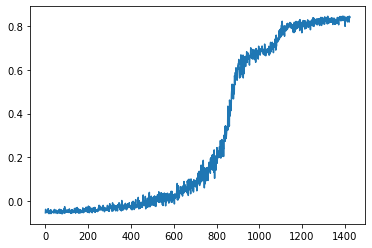

In [21]:
plt.plot(test_performance)

In [22]:
state=env.reset()
for timestep in range(1, max_steps_per_episode):
    state_tensor = tf.convert_to_tensor(state)
    state_tensor = tf.expand_dims(state_tensor, 0)
    action_probs = actor(state_tensor, training=False)
    critic_values = critic(state_tensor, training=False)
    action = np.argmax(np.squeeze(action_probs))
    state_next, reward, done = env.step(action)
    state_next = np.array(state_next, dtype=np.float32)
    state=state_next
    if done: break    
final_pops = evolve(env.rho0, env.H, env.T)
print(final_pops)

0.9073823783999281


In [23]:
print(state)

[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]


In [19]:
print(opt) #0.9906080718710916

[1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]


In [16]:
np.savetxt("PPOchain_grid21_NoSink_J_0_05_learning.csv", np.array(test_performance), delimiter=",")

In [17]:
actor.save("PPOchain_grid21_NoSink_J_0_05_actor")
critic.save("PPOchain_grid21_NoSink_J_0_05_critic")

INFO:tensorflow:Assets written to: PPOchain_grid21_NoSink_J_0_05_actor\assets
INFO:tensorflow:Assets written to: PPOchain_grid21_NoSink_J_0_05_critic\assets
